In [1]:
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cpu,floatX=float64
# optimizer=fast_run,NanGuardMode.action=warn
# use device=cuda for gpu support

env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cpu,floatX=float64


In [2]:
import sys
from __future__ import division
add = __builtin__.sum

In [3]:
from theano import clone, function, pp, shared
from theano.tensor import (concatenate, config, cosh, dot, erfinv, eq, grad, min,
                           scalar, scalars, shape_padright, sum, switch,
                           tensor3, tensor4, tensor5, TensorType, tile, vector)
from theano.tensor.var import TensorVariable
from theano.printing import debugprint, pydotprint
#from theano.tensor.shared_randomstreams import RandomStreams
# used later
from theano.tensor import roll, stack

In [4]:
from numpy import (array, arange, asarray, exp, full, Inf, linspace,
                   mean, meshgrid, pi, roll)
# used later
#from numpy import roll, stack

In [5]:
from sympy import (Abs, Eq, exp as Exp, I, init_printing, integrate,
                   oo, pi as Pi, solve, symbols, Symbol)
#from sympy.printing.theanocode
# added erfinv
from theanocode import theano_code, theano_function
#from pymatrix import matrix, Matrix

In [6]:
init_printing()

In [7]:
from IPython.display import display, HTML, SVG

In [8]:
%matplotlib inline
from matplotlib.pyplot import (axes, close, contour, contourf, figure,
                               legend, plot, rcParams, show, title,
                               xlabel, ylabel)
from matplotlib.cm import * #coolwarm, Spectral, etc.
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation

In [9]:
from sdict import select

In [10]:
from smatrix import *

In [11]:
# function of specified variables fun(y,...) from expression f
# where: fun(x,y)(f)(x,y) = f
def fun(*y):
    if isinstance(y[0],TensorVariable):
        return lambda f: lambda *x: clone(f, dict([[y[i],x[i]] for i in range(len(y))]),strict=False)
    else:
        return lambda f: lambda *x: f.subs( dict([[y[i],x[i]] for i in range(len(y))]))

#### Boundary Conditions

We introduce fictitious worlds, two worlds deep, at the edges of the array to represent boundary conditions. Boundry worlds can be removed or set to zero.

In [12]:
B=2
def boundary0(r):
    for i in range(r.ndim):
        rs = list(r.shape); rs[i]=1
        s = [1]*r.ndim; s[i]=B
        before1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        s = [1]*r.ndim; s[i]=B
        after1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        r = concatenate([before1,r,after1], axis=i)
    return r

In [13]:
def boundary(s): return stack([boundary0(r) for r in s])

In [14]:
def debound(r): return r[tuple([slice(B,-B)]*(r.ndim))]

In [15]:
# uniform grid between 0 and 1 of dimension d and size N
def grid(d,N):
    return array(meshgrid(*[arange(0.0+0.5/N,1.0,1.0/N,config.floatX)]*d,
                              indexing='ij'))

### Difference operator ###

Forward and backward differences

In [16]:
def d(dir,x,i):
    if dir<0:
        return roll(x, dir, axis = i) - x
    else:
        return x - roll(x, dir, axis = i)

#### Jacobian ####

In [17]:
def J(C): return matrix([[d(-1,C[j],i) for i in dim] for j in dim])

In [18]:
def K(C): return 1/J(C) # inverse

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [19]:
def Q(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           -hbar**2/(4*mu[j])*(K_C[k,j]*d(-1,d(+1,K_C[l,j], k), l) + d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)/2)
                 for k in dim]) for j in dim]) for l in dim]))

The gradient of just the $2^{nd}$ order term in Schiff&Poirier eq. 20 (differing only by the sign), yields the same quantum force as the full expression.
The discretized version of this expression is identical to that introduced by Hall & Deckart.

In [20]:
def Q2(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           hbar**2/(8*mu[j])*d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)
                 for k in dim]) for j in dim]) for l in dim]))

#### Quantum Force (Schiff & Poirier eq 18) ####

In [21]:
def R(hbar,mu,C):
    K_C=K(C)
    return stack([debound(add([add([add([add([
      hbar**2/(4*mu[j])*d(+1,K_C[k, i]*K_C[p, j]*d(-1,d(+1,K_C[l, j], k), l), p)
        for p in dim]) for k in dim]) for j in dim]) for l in dim]))
            for i in dim])

### Start with 1-D expressions ##

In [22]:
dim = range(1) # dimension

In [23]:
var=['x']

In the following use numpy's roll and stack functions for symbolic operations. Later we will use the same theano functions for numeric operations.

In [24]:
from numpy import roll, stack

In [25]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
hbar=Symbol('hbar')

The multidimensional symbolic array $s$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world. Provided the number of worlds is large enough the trace of Q will contain sufficient information to compute the force as a gradient.

In [26]:
N=9 # number of worlds

In [27]:
xb=array(meshgrid(*[symbols(['%s_{%s}'%(var[j].replace(' ',''),str(Symbol("i")+(i-N//2)).replace(' ','')) for i in range(N)]) for j in dim],indexing='ij'))

The sympy variable names display symbolic indices.

In [28]:
xb[0].tolist()

The index of the $i^{th}$ world with boundry worlds removed:

In [29]:
x=array(map(debound,xb))

In [30]:
ith = N//2-B
x_i=x[0][ith]
x_i

The quantum potential at each world:

In [32]:
Qs2=Q2(hbar,mu,xb)

The $i^{th}$ entry in this array is generic, i.e. independent of the worlds at the boundary. 

In [33]:
Qs2[ith]

We consider it as a function of its mass $\mu_0$ and 3 variables representing the positions of the particle in the $i^{th}$ world and immediately adjacent worlds .

In [34]:
[x[0][ith-i] for i in range(-1,2)]

In [35]:
Q1=fun(mu[0],*[x[0][ith-i] for i in range(-1,2)])(Qs2[ith])

Quantum force at each world:

In [36]:
Rs=R(hbar,mu,xb)
Rs.shape

Again, the $i^{th}$ entry in these arrays are generic, i.e. independent of the boundary worlds.

In [37]:
Rs[0,ith]

As expected, the discretized Schiff and Poirier expression for the quantum force is minus the gradient of the trace of the discretized quantum potential.

In [38]:
(Rs[0,ith] - -add([Qs2[i] for i in range(N-2*B)]).diff(x_i)).simplify()==0

True

We consider it as a function of its mass $\mu_0$ and 5 variables representing the positions of the particle in the $i^{th}$ world and two adjacent worlds to the left and right.

In [39]:
[x[0][ith-i] for i in range(-2,3)]

In [40]:
R1=fun(mu[0],*[x[0][ith-i] for i in range(-2,3)])(Rs[0,ith])

### In 3 dimensions ... ###

The generalization to higher dimensions/multiple particles is essentially trivial.

In [41]:
dim = range(3) # dimension

The multidimensional symbolic array $C$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world.

In [42]:
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

In [43]:
N=9

Symbolic grid.

In [44]:
var=['x','y','z']

In [45]:
xb=array(meshgrid(*[symbols(['%s_{%s}'%(var[j].replace(' ',''),str(Symbol("i")+(i-N//2)).replace(' ','')) for i in range(N)]) for j in dim],indexing='ij'))
xb.shape

In [46]:
xb[0,:,N//2,N//2].tolist()

In [47]:
xb[1,N//2,:,N//2].tolist()

In [48]:
xb[2,N//2,N//2,:].tolist()

The index of the $i^{th}$ world with boundry worlds removed:

In [49]:
x=array(map(debound,xb))

In [50]:
ith = N//2-B
x_i=x[0][ith,ith,ith]
y_i=x[1][ith,ith,ith]
z_i=x[2][ith,ith,ith]
(x_i,y_i,z_i)

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [51]:
hbar=Symbol('hbar') # Planck's constant

In [52]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
list(mu)

The quantum potential at the $i^{th}$ world:

In [53]:
Qs=Q(hbar,mu,xb)
Qs.shape

The $i^{th}$ entry in this array is generic, i.e. independent of the worlds at the boundary.

In [54]:
Qs[ith,ith,ith]

These are the same expressions in different variables! If we have computed the gradients properly this means that the quantum force is "separable".  The forces on each axis (orthogonal directions) are independent of each other. Therefore the generalization to higher dimensions/multiple particles is essentially trivial.

#### Quantum Force (Schiff&Poirier eq 18)####

In general the force is a vector.
Provided the number of worlds is large enough the trace of Q contains sufficient information to compute gradients.

In [56]:
Rs=R(hbar,mu,xb)
Rs.shape

Again, the $i^{th}$ entry in these arrays are generic, i.e. independent of the boundary worlds.

In [57]:
Rs[0,ith,ith,ith]

In [58]:
Rs[1,ith,ith,ith]

In [59]:
Rs[2,ith,ith,ith]

As expected, the discretized Schiff and Poirier expression for the quantum force is the gradient of the discretized quantum potential.

In [60]:
QU=add([Qs[i,i,i] for i in range(N-2*B)]) # trace

In [61]:
(Rs[0,ith,ith,ith].expand()==-QU.diff(x_i).expand() and
 Rs[1,ith,ith,ith].expand()==-QU.diff(y_i).expand() and
 Rs[2,ith,ith,ith].expand()==-QU.diff(z_i).expand())

True

It is also interesting to note that the gradient of a simpler potential, which differs from the $2^{nd}$ order term in Schiff&Poirier eq. 20 by only the sign, yields the same expression for the quantum force. This turns out to be the same quantum potential as introduced by Hall&Deckart.

In [62]:
Qs2=Q2(hbar,mu,xb)

The discretized version of this expression is identical to that introduced by Hall & Deckart.

In [63]:
Qs2[ith,ith,ith]

Gradient of the trace.

In [64]:
Q2R0 = -add([Qs2[i,i,i] for i in range(N-2*B)]).diff(x_i)
Q2R1 = -add([Qs2[i,i,i] for i in range(N-2*B)]).diff(y_i)
Q2R2 = -add([Qs2[i,i,i] for i in range(N-2*B)]).diff(z_i)

In [65]:
((Rs[0,ith,ith,ith] - Q2R0).simplify()==0 and
 (Rs[1,ith,ith,ith] - Q2R1).simplify()==0 and
 (Rs[2,ith,ith,ith] - Q2R2).simplify()==0)

True

The 3-dimensional quantum potential and force can be expressed in terms of the 1-dimensional expressions.

In [66]:
Qs2[ith,ith,ith] == add([Q1(mu[j],*[x[j][ith-i,ith-i,ith-i] for i in range(-1,2)]) for j in dim])

True

In [67]:
all([Rs[j,ith,ith,ith]==R1(mu[j],*[x[j][ith-i,ith-i,ith-i] for i in range(-2,3)]) for j in dim])

True

### Numeric computation ###

These expressions can be converted directly to Theano functions for efficient execution on gpu and multicore processors.

In [68]:
from theano.tensor import roll, stack

In [69]:
hbar_s = theano_code(hbar)
mu_v = vector('mu')

Without sympy simplification Theano would produce the following expressions (disabled below since they are not needed in this worksheet):

$3^{rd}$ order potential

In [70]:
#Q_=function([hbar_s,mu_v,C],Q(hbar_s,mu_v,C))
#pp(Q_.maker.fgraph.outputs[0])

$2^{nd}$ order potential

In [71]:
#Q2_=function([hbar_s,mu_v,C],Q2(hbar_s,mu_v,C))
#pp(Q2_.maker.fgraph.outputs[0])

Quantum force

In [72]:
#R_=function([hbar_s,mu_v,C],R(hbar_s,mu_v,C))
#pp(R_.maker.fgraph.outputs[0])

Even after Theano graph optimization the functions obtained from the sympy simplified expressions above are shorter than those produced directly by Theano. To conversion the sympy expressions to Theano, we just need to replace symbols with appropriate vector operators:

In [73]:
ro2=dict(
     # replace mu scalars with vector
     [[theano_code(mu[i]),mu_v[i]] for i in dim]+
     # replace subscripted symbols with vector operators
     [[theano_code(x[j,ith-i,ith-i,ith-i]),roll(C[j],i,axis=j)] for j in dim for i in range(-2,3)])

In [74]:
Q2b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Qs2[ith,ith,ith]),ro2,strict=False)))
Q2b_=function([hbar_s,mu_v,C],Q2b(hbar_s,mu_v,C))
#SVG(pydotprint(Q2b_.maker.fgraph.outputs[0], return_image=True, format='svg'))

In [75]:
Rb=fun(hbar_s,mu_v,C)(stack([debound(clone(theano_code(Rs[i,ith,ith,ith]),ro2,strict=False)) for i in dim]))
Rb_=function([hbar_s,mu_v,C],Rb(hbar_s,mu_v,C))

#### Density ####

In [76]:
D_ = function([C],debound(1/J(C).determinant()))

### Simulation ###

Using the expressions derived above we can generate efficient numerical functions which we use later in determining the motion of a particle in many worlds simultaneously.

We use the discrete difference approximation to Poirier's equations above for a numerical simulation of quantum motion in a small number of ``parallel'' worlds.

#### Classical Potential ####

In [77]:
x1,y1,z1=scalars('x1','y1','z1')

In [78]:
# central potential for 1 particle in 3 dimmensions
V = fun(x1,y1,z1) (0.1*(x1**2+y1**2+z1**2))

In [79]:
V_ = function([C],V(C[0],C[1],C[2]))

In [80]:
testgrid = 49*(grid(3,49)-0.5)

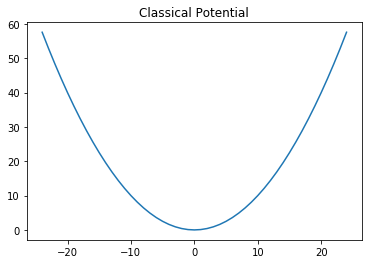

In [81]:
plot(49*(grid(1,49)-0.5)[0],V_(testgrid)[:,24,24])
title('Classical Potential')
show()

#### Classical Force ####

In [82]:
# theano symbolic gradient
Fx1 = fun(x1,y1,z1) (-grad(V(x1,y1,z1),x1))
Fy1 = fun(x1,y1,z1) (-grad(V(x1,y1,z1),y1))
Fz1 = fun(x1,y1,z1) (-grad(V(x1,y1,z1),z1))

In [83]:
F_ = function([C],stack([Fx1(C[0],C[1],C[2]),Fy1(C[0],C[1],C[2]),Fz1(C[0],C[1],C[2])]))

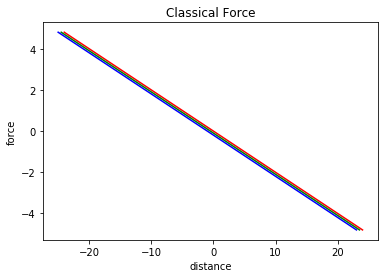

In [84]:
plot(49*(grid(1,49)-0.5)[0],F_(49*(grid(3,49)-0.5))[0][:,24,24],
     color='red')
plot(49*(grid(1,49)-0.51)[0],F_(49*(grid(3,49)-0.5))[1][24,:,24],
     color='green')
plot(49*(grid(1,49)-0.52)[0],F_(49*(grid(3,49)-0.5))[2][24,24,:],
     color='blue')
title('Classical Force')
xlabel('distance'); ylabel('force')
show()

### Initial Data ###

In order to compute the quantum force on the particles in world $n$ we introduce four widely separated fictitious particles in worlds to the left and right to represent open boundary conditions.

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ "parallel" worlds.

In [85]:
N = 20

#### Spatial Distribution

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ ``parallel'' worlds. Everything is in atomic units below, so $\hbar=1$.

In [86]:
bxy=2*(grid(3,N+2*B)-0.5); bxy.shape

In [87]:
xy=array(list(map(debound,bxy))); xy.shape

In [88]:
def gauss3(f,xy): return stack([f[0](xy[0]),f[1](xy[1]),f[2](xy[2])])

In [89]:
b0=gauss3([lambda x:erfinv(x),lambda x:0.5*erfinv(x),lambda x:0.25*erfinv(x)],bxy).eval()
b0 *= 10**12; b0[:,1:-1,1:-1,1:-1] *= 10**-6; b0[:,2:-2,2:-2,2:-2] *= 10**-6
b0.shape

In [90]:
p0 = array(list(map(debound,b0)))
p0.shape

#### Distribution of Velocity ####
The particles have an identical initial velocity in each world of

In [91]:
v0=full(b0.shape,0.0,config.floatX)

We will use numeric functions based on the simplified sympy expressions for the quantum potential and force in the following simulation.

#### Acceleration ####

In [92]:
def boundary2(s): return stack([boundary0(s[i]) for i in dim])

In [93]:
def debound2(s): return stack([debound(s[i]) for i in dim])

In [94]:
def F(C): return stack([
            Fx1(C[0],C[1],C[2]),
            Fy1(C[0],C[1],C[2]),
            Fz1(C[0],C[1],C[2])])

In [95]:
def A(hbar,mu,x):
    return shape_padright(1/mu,3)*boundary2(F(debound2(x)) + Rb(hbar,mu,x))

#### Step Size Controller ####
Continuous integrating step size controller \cite{hairer2005}

In [96]:
def G(a,v,alpha):
    eps = 1e-12
    g1 = sum(a*v)
    g2 = sum(v**2)
    return switch(eq(g2,0),1/eps,-alpha*g1/g2)

#### Integration ####
Integrate using the Störmer–Verlet algorithm with adaptive step size.

In [97]:
mu = array([1.0,1.0,1.0])  # mass
hbar = 0.2 # Planck's constant
rho = shared(asarray(1.0, config.floatX),'rho') # step size control
alpha = scalar('alpha') # sensitivity
ds = scalar('ds')
dt = ds/rho
t = shared(asarray(0.0, config.floatX))
x = shared(b0)

In [98]:
a0 = A(hbar,mu,x).eval()

In [99]:
a = shared(a0)
v = shared(v0)
x_new = x+v*dt+0.5*a*dt**2
a_new = A(hbar,mu,x_new)
v_new = v+0.5*a*dt+0.5*a_new*dt

In [100]:
VerletStep = function([ds,alpha],t, updates=[
    (rho, rho + G(a_new,v_new,alpha)*dt ),
    (x, x_new ),
    (v, v_new ),
    (a, a_new ),
    (t, t + dt)
]) #,allow_input_downcast=True)

#### Energy ####

In [101]:
KU1 = 0.5*sum(mu[0]*v[0]**2+mu[1]*v[1]**2+mu[2]*v[2]**2)  # total kinetic energy
PU1 = sum(debound(V(x[0],x[1],x[2])))             # total classical potential
QU1 = sum(Q2b(hbar,mu,x))                         # total quantum potential
E_ = function([],[KU1,PU1,QU1])

In [102]:
E_()

[array(0.0), array(256.2227068430163), array(4611.876824156633)]

In [103]:
crossing=function([],min([debound(d(-1,x[0],0)),debound(d(-1,x[1],1)),debound(d(-1,x[2],2))])<0)

In [104]:
t_start = 0.0; t_end = 14.2
t_samples = 100; x_samples = N
alpha = 0.0
t_sample = t_end/t_samples
x_sample = __builtin__.max(1,int(N)//int(x_samples))
x_start = __builtin__.max(0,int(N-x_samples*x_sample)//int(2))
XS = array(range(B+x_start,B+N-x_start,x_sample))
ds0 = 0.0001 # N=20 # initial step size
dsn = 1 # initial step size divider

In [105]:
while True:
    try: # step size
        ds = ds0/dsn
        # initial values
        rho.set_value(1.0)
        t.set_value(0.0)
        x.set_value(b0)
        v.set_value(v0)
        a.set_value(a0)
        # data recording
        T = [] # sample times
        Rho = select({}) # steo size
        XX = select({}) # position
        XV = select({}) # velocity
        TK = select({}) # kinetic energy
        TP = select({}) # classical potential
        TQ = select({}) # quantum potential
        E = select({})  # total energy
        try:
            t0 = t.get_value().item()
            while t0<t_end:
                t1 = t0 + t_sample
                [TK[t0], TP[t0], TQ[t0]] = E_(); E[t0] = TK[t0]+TP[t0]+TQ[t0]
                if len(E)>1 and abs(E[t0]-E0)>1.0: raise ValueError(
                     "Energy conservation bound failed at %s. Delta E:"\
                    "|%s| > 1.0."%(t0,E[t0]-E0))
                else: E0 = E[t0]
                if t0>=t_start:
                    T += [t0] # record
                    XX[t0] = x.get_value()[:,XS][:,:,XS][:,:,:,XS]
                    XV[t0] = v.get_value()[:,XS][:,:,XS][:,:,:,XS]
                    Rho[t0] = rho.get_value().item()
                    print("t = %s t1 = %s rho = %s E1 = %s"%(t0,t1,Rho[t0],E0))
                while t0<t1: # loop
                    t0 = VerletStep(ds,alpha).item()
                    rho0 = rho.get_value().item()
                    if rho0 > 100 or rho0 < 0.01:
                        raise ValueError("Step control failed at %s. rho=%s"%(t0,rho0))
                # Check no-crossing
                if crossing(): raise ValueError("crossing at %s",t0)
                # Check total energy conservation
        except KeyboardInterrupt:
            print("Interrupted at %s ..."%(t0))
        break # success!
    except ValueError as msg:
        print(msg)
        #break
        dsn = dsn + 1
        print("Trying a shorter initial step size: %s."%(ds0/dsn))
        continue
T=array(T); tmax = T[-1]
print("t = %d"%tmax)

t = 0.0 t1 = 0.142 rho = 1.0 E1 = 4868.099531


t = 0.142 t1 = 0.284 rho = 1.0 E1 = 4868.07836043


t = 0.2841 t1 = 0.4261 rho = 1.0 E1 = 4868.08129503


t = 0.4262 t1 = 0.5682 rho = 1.0 E1 = 4868.08158067


t = 0.5683 t1 = 0.7103 rho = 1.0 E1 = 4868.08162772


t = 0.7104 t1 = 0.8524 rho = 1.0 E1 = 4868.08170154


t = 0.8525 t1 = 0.9945 rho = 1.0 E1 = 4868.08169662


t = 0.9946 t1 = 1.1366 rho = 1.0 E1 = 4868.08171544


t = 1.1367 t1 = 1.2787 rho = 1.0 E1 = 4868.08172173


t = 1.2788 t1 = 1.4208 rho = 1.0 E1 = 4868.08172035


t = 1.4209 t1 = 1.5629 rho = 1.0 E1 = 4868.08171857


t = 1.563 t1 = 1.705 rho = 1.0 E1 = 4868.08171396


t = 1.7051 t1 = 1.8471 rho = 1.0 E1 = 4868.08171587


t = 1.8472 t1 = 1.9892 rho = 1.0 E1 = 4868.08171771


t = 1.9893 t1 = 2.1313 rho = 1.0 E1 = 4868.08171691


t = 2.1313 t1 = 2.2733 rho = 1.0 E1 = 4868.08171467


t = 2.2733 t1 = 2.4153 rho = 1.0 E1 = 4868.08170889


t = 2.4153 t1 = 2.5573 rho = 1.0 E1 = 4868.08171482


t = 2.5573 t1 = 2.6993 rho = 1.0 E1 = 4868.08170898


t = 2.6993 t1 = 2.8413 rho = 1.0 E1 = 4868.08171441


t = 2.8413 t1 = 2.9833 rho = 1.0 E1 = 4868.08171456


t = 2.9833 t1 = 3.1253 rho = 1.0 E1 = 4868.08171858


t = 3.1253 t1 = 3.2673 rho = 1.0 E1 = 4868.08172015


t = 3.2673 t1 = 3.4093 rho = 1.0 E1 = 4868.08171739


t = 3.4093 t1 = 3.5513 rho = 1.0 E1 = 4868.08172229


t = 3.5513 t1 = 3.6933 rho = 1.0 E1 = 4868.0817177


t = 3.6933 t1 = 3.8353 rho = 1.0 E1 = 4868.08171231


t = 3.8353 t1 = 3.9773 rho = 1.0 E1 = 4868.08171624


t = 3.9773 t1 = 4.1193 rho = 1.0 E1 = 4868.08171811


t = 4.1194 t1 = 4.2614 rho = 1.0 E1 = 4868.08171885


t = 4.2615 t1 = 4.4035 rho = 1.0 E1 = 4868.08170636


t = 4.4036 t1 = 4.5456 rho = 1.0 E1 = 4868.08171808


t = 4.5457 t1 = 4.6877 rho = 1.0 E1 = 4868.08170929


t = 4.6878 t1 = 4.8298 rho = 1.0 E1 = 4868.08170526


t = 4.8299 t1 = 4.9719 rho = 1.0 E1 = 4868.08172343


t = 4.972 t1 = 5.114 rho = 1.0 E1 = 4868.0817098


t = 5.1141 t1 = 5.2561 rho = 1.0 E1 = 4868.08168721


t = 5.2562 t1 = 5.3982 rho = 1.0 E1 = 4868.08169714


t = 5.3983 t1 = 5.5403 rho = 1.0 E1 = 4868.08170723


t = 5.5404 t1 = 5.6824 rho = 1.0 E1 = 4868.08169151


t = 5.6825 t1 = 5.8245 rho = 1.0 E1 = 4868.08174508


t = 5.8246 t1 = 5.9666 rho = 1.0 E1 = 4868.08169364


t = 5.9667 t1 = 6.1087 rho = 1.0 E1 = 4868.08166485


t = 6.1088 t1 = 6.2508 rho = 1.0 E1 = 4868.0816893


t = 6.2509 t1 = 6.3929 rho = 1.0 E1 = 4868.0816309


t = 6.393 t1 = 6.535 rho = 1.0 E1 = 4868.08147823


t = 6.5351 t1 = 6.6771 rho = 1.0 E1 = 4868.08154537


t = 6.6772 t1 = 6.8192 rho = 1.0 E1 = 4868.08059149


t = 6.8193 t1 = 6.9613 rho = 1.0 E1 = 4868.08340449


t = 6.9614 t1 = 7.1034 rho = 1.0 E1 = 4868.04743459


t = 7.1035 t1 = 7.2455 rho = 1.0 E1 = 4867.95724955


t = 7.2456 t1 = 7.3876 rho = 1.0 E1 = 4868.07688943


t = 7.3877 t1 = 7.5297 rho = 1.0 E1 = 4868.0826278


t = 7.5298 t1 = 7.6718 rho = 1.0 E1 = 4868.08193351


t = 7.6719 t1 = 7.8139 rho = 1.0 E1 = 4868.08158878


t = 7.814 t1 = 7.956 rho = 1.0 E1 = 4868.08166154


t = 7.95609999999 t1 = 8.09809999999 rho = 1.0 E1 = 4868.0816576


t = 8.09819999999 t1 = 8.24019999999 rho = 1.0 E1 = 4868.08172639


t = 8.24029999999 t1 = 8.38229999999 rho = 1.0 E1 = 4868.08161895


t = 8.38239999999 t1 = 8.52439999999 rho = 1.0 E1 = 4868.08172634


t = 8.52449999999 t1 = 8.66649999999 rho = 1.0 E1 = 4868.08171172


t = 8.66659999999 t1 = 8.80859999999 rho = 1.0 E1 = 4868.08162693


t = 8.80869999999 t1 = 8.95069999999 rho = 1.0 E1 = 4868.08169128


t = 8.95079999999 t1 = 9.09279999999 rho = 1.0 E1 = 4868.08172842


t = 9.09289999999 t1 = 9.23489999999 rho = 1.0 E1 = 4868.08171234


t = 9.23499999999 t1 = 9.37699999999 rho = 1.0 E1 = 4868.08169558


t = 9.37709999999 t1 = 9.51909999999 rho = 1.0 E1 = 4868.08169444


t = 9.51919999999 t1 = 9.66119999999 rho = 1.0 E1 = 4868.08172437


t = 9.66129999999 t1 = 9.80329999999 rho = 1.0 E1 = 4868.08169995


t = 9.80339999999 t1 = 9.94539999999 rho = 1.0 E1 = 4868.08171975


t = 9.94549999999 t1 = 10.0875 rho = 1.0 E1 = 4868.08170731


t = 10.0876 t1 = 10.2296 rho = 1.0 E1 = 4868.08172721


t = 10.2297 t1 = 10.3717 rho = 1.0 E1 = 4868.08169903


t = 10.3718 t1 = 10.5138 rho = 1.0 E1 = 4868.08171199


t = 10.5139 t1 = 10.6559 rho = 1.0 E1 = 4868.08171232


t = 10.656 t1 = 10.798 rho = 1.0 E1 = 4868.08170358


t = 10.7981 t1 = 10.9401 rho = 1.0 E1 = 4868.0816809


t = 10.9402 t1 = 11.0822 rho = 1.0 E1 = 4868.08167722


t = 11.0823 t1 = 11.2243 rho = 1.0 E1 = 4868.08170513


t = 11.2244 t1 = 11.3664 rho = 1.0 E1 = 4868.08167461


t = 11.3665 t1 = 11.5085 rho = 1.0 E1 = 4868.08174326


t = 11.5086 t1 = 11.6506 rho = 1.0 E1 = 4868.08168561


t = 11.6507 t1 = 11.7927 rho = 1.0 E1 = 4868.08172229


t = 11.7928 t1 = 11.9348 rho = 1.0 E1 = 4868.08165983


t = 11.9349 t1 = 12.0769 rho = 1.0 E1 = 4868.08169012


t = 12.077 t1 = 12.219 rho = 1.0 E1 = 4868.08168554


t = 12.2191 t1 = 12.3611 rho = 1.0 E1 = 4868.08173028


t = 12.3612 t1 = 12.5032 rho = 1.0 E1 = 4868.08163764


t = 12.5033 t1 = 12.6453 rho = 1.0 E1 = 4868.08176139


t = 12.6454 t1 = 12.7874 rho = 1.0 E1 = 4868.08179247


t = 12.7875 t1 = 12.9295 rho = 1.0 E1 = 4868.0815998


t = 12.9296 t1 = 13.0716 rho = 1.0 E1 = 4868.08168439


t = 13.0717 t1 = 13.2137 rho = 1.0 E1 = 4868.0817026


t = 13.2138 t1 = 13.3558 rho = 1.0 E1 = 4868.08172653


t = 13.3559 t1 = 13.4979 rho = 1.0 E1 = 4868.08139572


t = 13.498 t1 = 13.64 rho = 1.0 E1 = 4868.08192651


t = 13.6401 t1 = 13.7821 rho = 1.0 E1 = 4868.08015971


t = 13.7822 t1 = 13.9242 rho = 1.0 E1 = 4868.07914845


t = 13.9243 t1 = 14.0663 rho = 1.0 E1 = 4868.09690098


t = 14.0664 t1 = 14.2084 rho = 1.0 E1 = 4867.70239795


t = 14


Step Density

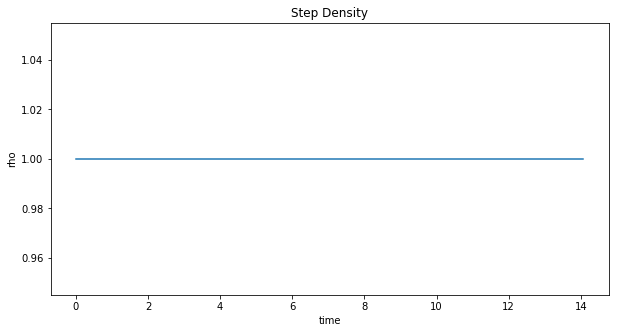

In [115]:
figure(figsize=(10,5))
plot(T, Rho[T])
title('Step Density')
xlabel('time'); ylabel('rho')
show()

#### Quantum Potential, Classical Potential and Kinetic Energy ####

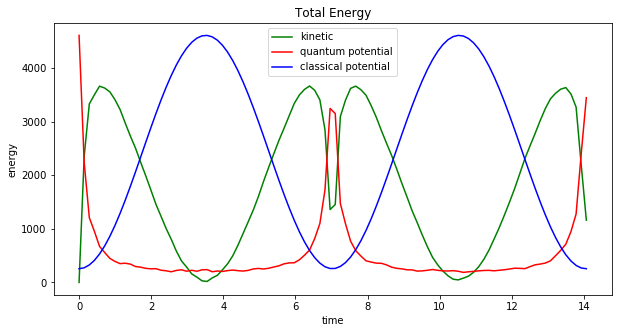

In [116]:
figure(figsize=(10,5))
plot(T, TK[T],color='green',label='kinetic')
plot(T, TQ[T],color='red',label='quantum potential')
plot(T, TP[T],color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

#### Energy Conservation ####

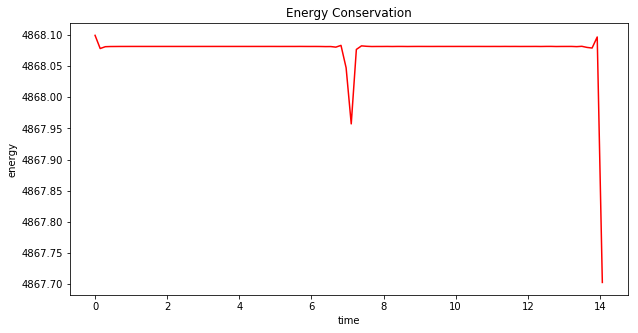

In [117]:
figure(figsize=(10,5))
plot(T, TK[T]+TP[T]+TQ[T],color='red')
title('Energy Conservation')
xlabel('time'); ylabel('energy')
show()

#### Trajectories ####
The trajectory of the particle in each world is shown below.  Notice how the trajectories do not cross, yet in some worlds the particle is scattered from the barrier while in others the particle tunnels across the barrier "pushed" by its counterpart in other worlds.

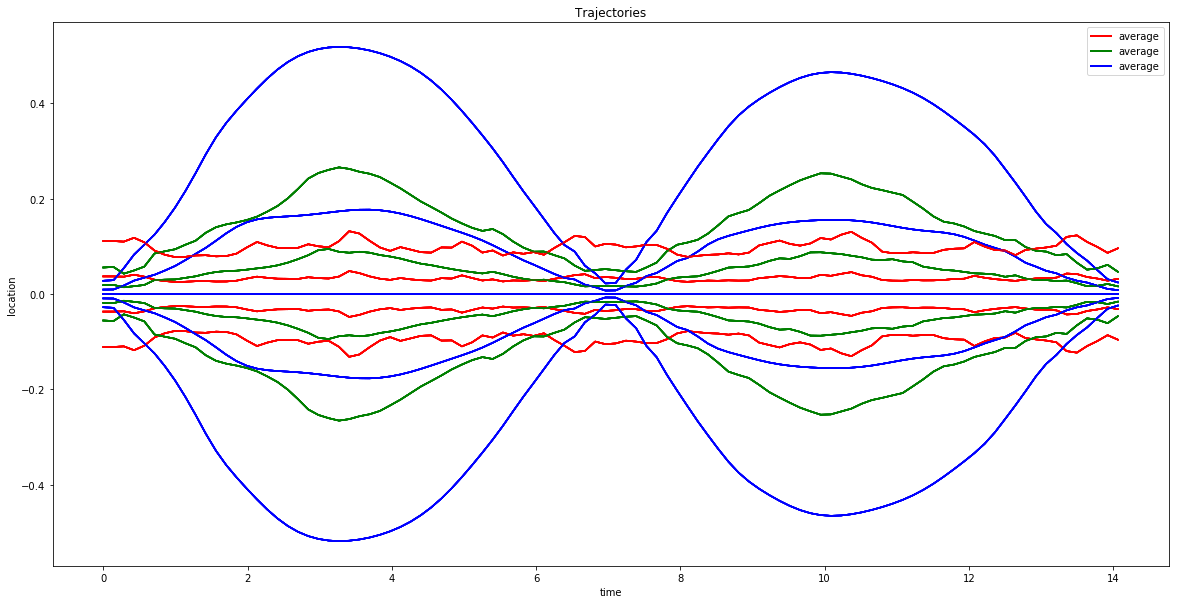

In [118]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2,3)), color='red',label='average',linewidth=2)
plot(T, mean(XX[T][:,1],(1,2,3)), color='green',label='average',linewidth=2)
plot(T, mean(XX[T][:,2],(1,2,3)), color='blue',label='average',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(8,len(XS)-8):
    for j in range(8,len(XS)-8):
        for k in range(8,len(XS)-8):
            plot(T, XX[T][:,0,i,j,k],color='red',alpha=0.5)
            plot(T, XX[T][:,1,i,j,k],color='green',alpha=0.5)
            plot(T, XX[T][:,2,i,j,k],color='blue',alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

#### Final Distribution ####

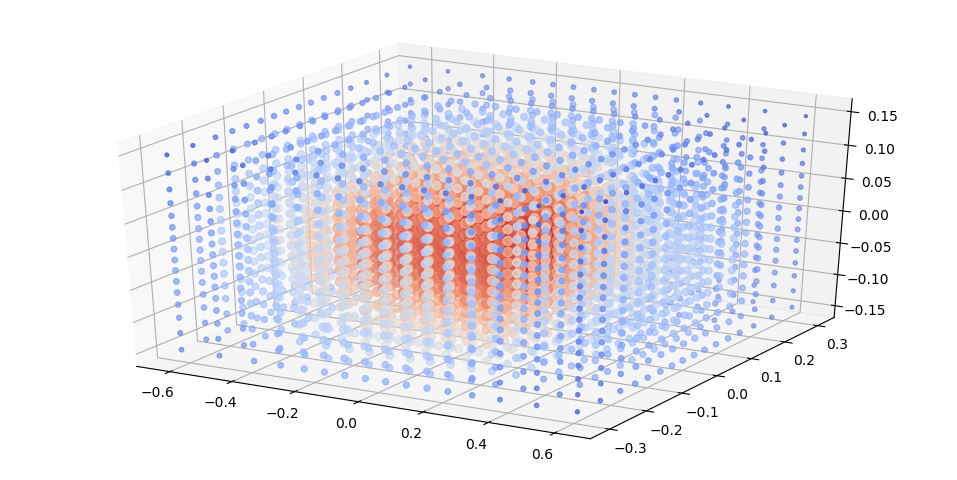

In [119]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.gca(projection='3d')
graph=ax1.scatter(debound(XX[tmax][0]),debound(XX[tmax][1]),debound(XX[tmax][2]),s=D_(XX[tmax])/500,c=D_(XX[tmax])/500,cmap=coolwarm)
#graph._offsets3d = (debound(XX[T[0]][0]).flatten(),debound(XX[T[0]][1]).flatten(),debound(XX[T[0]][2]).flatten())
graph
show()

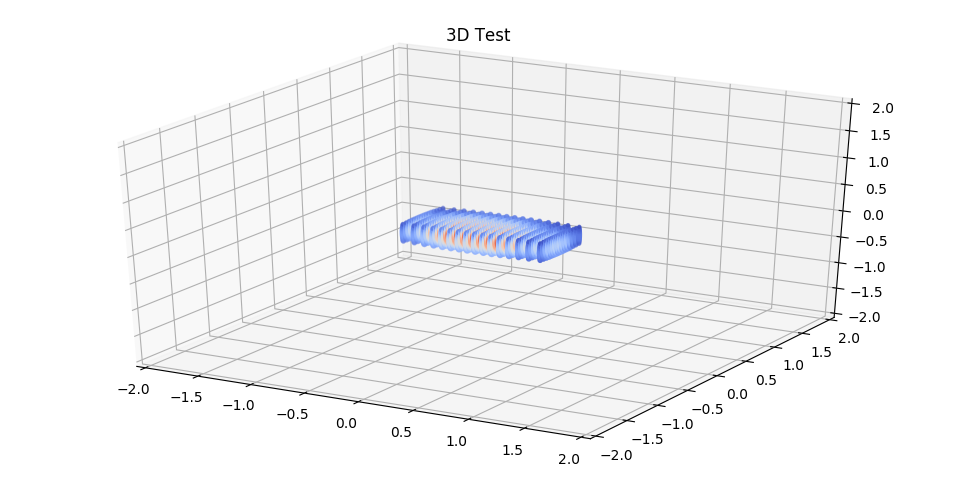

In [106]:
def update_graph(t):
    graph._offsets3d = (debound(XX[t][0]).flatten(),debound(XX[t][1]).flatten(),debound(XX[t][2]).flatten())
fig = figure(figsize=(12,6),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0,2.0)
ax.set_ylim3d(-2.0,2.0)
ax.set_zlim3d(-2.0,2.0)
title = ax.set_title('3D Test')

graph = ax.scatter(debound(XX[tmax][0]),debound(XX[tmax][1]),debound(XX[tmax][2]),
                  s=D_(XX[tmax])/500,c=D_(XX[tmax])/500,cmap=coolwarm)

ani = animation.FuncAnimation(fig, update_graph, frames=T, interval=500)
update_graph(tmax)
graph
show()
close()
#HTML(ani.to_html5_video())

In [107]:
HTML(ani.to_html5_video())

In [112]:
#ani.save('test2.mp4','ffmpeg')